# Homework 4

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

In this homework, we will use Credit Card Data from book "Econometric Analysis".

Here's a wget-able link:

wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column card).

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv')
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


Preparation

- Create the target variable by mapping yes to 1 and no to 0.
- Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1.


In [3]:
df['card'] = (df.card == 'yes').astype('int')
df['card']

0       1
1       1
2       1
3       1
4       1
       ..
1314    1
1315    0
1316    1
1317    1
1318    1
Name: card, Length: 1319, dtype: int32

In [4]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [5]:
from sklearn.model_selection import train_test_split

In [7]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [8]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [9]:
y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

In [10]:
del df_train['card']
del df_val['card']
del df_test['card']

In [11]:
len(df_train),len(df_val), len(df_test)

(791, 264, 264)

Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

- For each numerical variable, use it as score and compute AUC with the card variable.
- Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front(e.g. -df_train['expenditure'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable has the highest AUC?

In [12]:
from sklearn.metrics import roc_auc_score

In [13]:
from sklearn.metrics import roc_auc_score

for col in ['reports','dependents','active','share']:
    print(col)
    roc_auc = roc_auc_score(y_train, df_train[col])
    if roc_auc < 0.5:
        roc_auc = roc_auc_score(y_train, -df_train[col])
    print(f"score: {roc_auc}")

reports
score: 0.7166629860689376
dependents
score: 0.5327757227773791
active
score: 0.6043173411362006
share
score: 0.989183643423692


Training the model

From now on, use these columns only:

["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)


Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [14]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [15]:
def train(df,y):
    dicts = df.to_dict(orient= 'records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear',C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [16]:
dv, model = train(df_train[["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]], y_train)

In [17]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X= dv.transform(dicts)

    y_pred= model.predict_proba(X)[:,1]

    return y_pred

In [18]:
y_pred = predict(df_val[["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]], dv, model)

In [19]:
roc_auc_score(y_val,y_pred)

0.995171242063847

Question 3

Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

In [20]:
thresholds = np.arange(0.0,1.0, step=0.01)
actual_positive = (y_val== 1)
actual_negative = (y_val== 0)

recall_score = []
precision_score = []

for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    TP = (predict_positive & actual_positive).sum()
    TN = (predict_negative & actual_negative).sum()

    FP = (predict_positive & actual_negative).sum()
    FN = (predict_negative & actual_positive).sum()

    precision_cm = TP / (TP + FP)
    recall_cm = TP / (TP + FN)

    precision_score.append(precision_cm)
    recall_score.append(recall_cm)


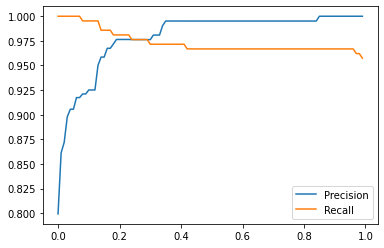

In [21]:
plt.plot(thresholds, precision_score, label='Precision')
plt.plot(thresholds, recall_score,label='Recall')
plt.legend()
plt.show()

Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

In [26]:
f1_score = []
for i in range(len(precision_score)):
    f1 = 2 * precision_score[i]* recall_score[i] / ( precision_score[i] + recall_score[i])
    f1_score.append(f1)


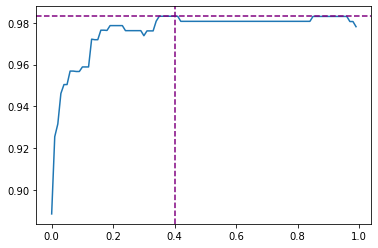

In [33]:
plt.plot(thresholds, f1_score,label='F1')
plt.axvline(0.4, linestyle= '--', color='purple')
plt.axhline(max(f1_score), linestyle= '--', color='purple')
plt.show()

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation

How large is standard devidation of the AUC scores across different folds?

In [34]:
from sklearn.model_selection import KFold

In [35]:
KFold= KFold(n_splits=5, shuffle=True, random_state=1)

In [39]:
scores = []

for train_idx, val_idx in KFold.split(df_full_train):
        
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model  = train(df_train[["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]], y_train)
        y_pred = predict(df_val[["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]], dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

In [40]:
print(f'mean score:{np.mean(scores)}, standard deviation:{np.std(scores)}')

mean score:0.9964498276814243, standard deviation:0.0027434713804377724


In [41]:
def train_q6(df,y, C):
    dicts = df.to_dict(orient= 'records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear',C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [49]:
C = [0.01,0.1,1,10]
scores_q6 = []
for c in C:
    
    for train_idx, val_idx in KFold.split(df_full_train):
            
            df_train = df_full_train.iloc[train_idx]
            df_val = df_full_train.iloc[val_idx]

            y_train = df_train.card.values
            y_val = df_val.card.values

            dv, model  = train_q6(df_train[["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]], y_train,c)
            y_pred = predict(df_val[["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]], dv, model)

            auc = roc_auc_score(y_val, y_pred)
            scores_q6.append(auc)
            
    print(f"C: {c}, mean score: {round(np.mean(scores),4)}")

C: 0.01, mean score: 0.9964
C: 0.1, mean score: 0.9964
C: 1, mean score: 0.9964
C: 10, mean score: 0.9964
